## TP2: Interação e Concorrência

# Grupo 16
<li>a85481 Bruno Miguel Pinheiro Alves</li>
<li>a85670 Daniel Martins Carvalho Ferreira</li>

Cada grupo de alunos tem um número, N, que lhes foi atribuído. O objetivo é utilizar um algoritmo quântico para procurar s

                s = N mod 8
              
numa lista desordenada.

In [1]:
N = 16

s = N % 8

s

0

Convertendo s em binário:

In [2]:
sb = bin(s)[2:]
print(sb)

0


Uma vez que 7 = 111 em formato binário. Precisamos de 3 qubits

In [3]:
n_qubits = 3

print("Numero de qubits precisos =",n_qubits)

Numero de qubits precisos = 3


## Algoritmo

O algoritmo que vamos implementar é o $\textbf{algoritmo de Grover}$.
Com este algoritmo é possível encontrar o valor suposto em $\sqrt{M}$ vezes, onde M corresponde ao número de elementos da lista.

Seja então $\textbf{s}$ o elemento que queremos encontrar, para usar este algoritmo vamos precisar de um $\textbf{oráculo}$ tal que:

$$f(x)=0$$
$$f(s)=1$$

Dessa forma no oráculo temos,

$O_f  \lvert x \rangle $=$(-1)^{f(x)}  \lvert x \rangle $ ou seja, se $f(x) = 0$ o elemento não sofre alteração e se $f(x) = 1$ (for o elemento que procuramos) então o elemento passa a ter sinal negativo.

Posto isto, as 3 fases do algoritmo de Grover podem ser vistas na seguinte imagem: 

<img src="https://scx2.b-cdn.net/gfx/news/2018/groversearch.jpg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="800 px" align="center">

Para o nosso caso, uma vez que $\textbf{M = 8}$ , temos $\sqrt{8} \approx 3$ 

In [4]:
# importing Qiskit
from qiskit import *

from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

backend_state = Aer.get_backend("statevector_simulator")
backend_qasm = Aer.get_backend('qasm_simulator')
backend_unitary = Aer.get_backend('unitary_simulator')

Começamos então por criar um circuíto com 3 qubits e aplicamos gates Hadamard em todos para obtermos uma $\textbf{sobreposição uniforme}$.

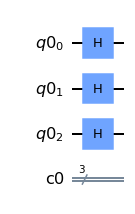

In [5]:
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
qc = QuantumCircuit(qr,cr)

for i in range(n_qubits):
    qc.h(i)
    
qc.draw(output='mpl')

Passamos agora à criação do oráculo para a mudança de fase. Pretende-se mudar a fase do elemento que corresponde ao que procuramos:

$$ U_f \lvert s \rangle = - \lvert s \rangle$$

$$ U_f \lvert s \rangle = \frac{1}{\sqrt{8}}(-\lvert 000 \rangle + \lvert 001 \rangle + \lvert 010 \rangle + \lvert 011 \rangle + \lvert 100 \rangle + \lvert 101 \rangle + \lvert 110 \rangle + \lvert 111 \rangle$$

Para mudarmos a fase do elemento que queremos, temos de aplicar gates $\textbf{X}$ aos qubits que queremos a zero. Também precisamos de aplicar a gate $\textbf{CCZ}$ mas, uma vez que esta não está definida em qiskit, aplicamos uma combinação equivalente : $\textbf{H CCX H}$

Primeiro, para testar o oráculo e verificar que este funciona de forma esperada, vamos criar o seguinte circuíto de teste:

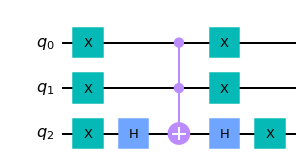

In [6]:
oracle_test = QuantumCircuit(n_qubits)
# Oráculo de mudança de fase para |000>
oracle_test.x(0)
oracle_test.x(1)
oracle_test.x(2)
oracle_test.h(2)
oracle_test.ccx(0,1,2)
oracle_test.h(2)
oracle_test.x(2)
oracle_test.x(1)
oracle_test.x(0)

oracle_test.draw(output='mpl')

In [7]:
backend_unitary = Aer.get_backend('unitary_simulator')
job = execute(oracle_test, backend_unitary)
result = job.result()
unitary_matrix = result.get_unitary(oracle_test, decimals=3)
print(unitary_matrix.real)

[[-1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [-0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]


Pela matriz anterior podemos perceber que a única fase que obteve mudança foi a fase 000, tal como era suposto.

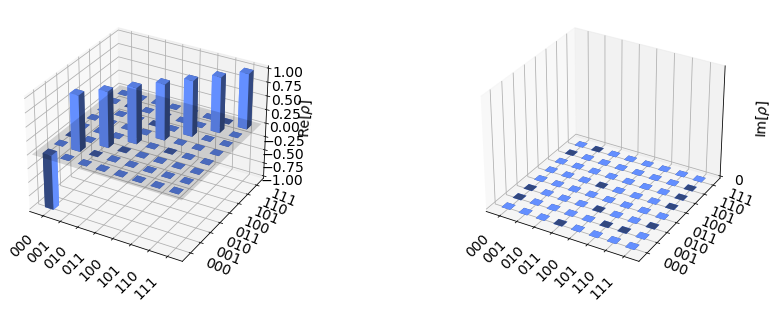

In [8]:
plot_state_city(unitary_matrix)

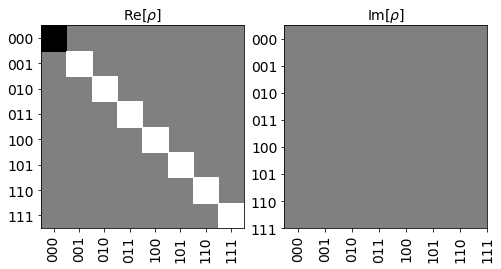

In [9]:
plot_state_hinton(unitary_matrix)

Construímos então a função $\textbf{phase_oracle}$ que recebe como argumento o circuíto no qual irá aplicar o oráculo

In [10]:
def phase_oracle(circuit):
    """Oráculo de mudança de fase para o número 000"""
    circuit.x(0)
    circuit.x(1)
    circuit.x(2)
    
    circuit.h(2)
    circuit.ccx(0,1,2)
    circuit.h(2)
    
    circuit.x(2)
    circuit.x(1)
    circuit.x(0)

Agora, para a fase de $\textbf{amplificação}$ do algoritmo de Grover. O objetivo desta fase é aumentar significativamente a probabilidade de encontrar $\textbf{s}$ na nossa lista. Isto é feito invertendo a amplitude de todos os estados e, além disso, amplificar a amplitude do elemento que queremos encontrar.

In [11]:
def diffuser(circuit):
    """Amplifica a probabilidade do elemento pretendido"""
    for i in range(n_qubits):
        circuit.h(i)
        circuit.x(i) 

    #ccz
    circuit.h(2)
    circuit.ccx(0,1,2)
    circuit.h(2)  
        
    for i in range(n_qubits):
        circuit.x(i)
        circuit.h(i)

### Implementação do algoritmo de Grover

Vão ser criados 3 circuítos. Um com apenas 1 iteração, um com 2 iterações e outro com 3 iterações.

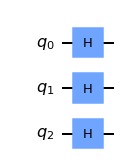

In [12]:
qc_1 = QuantumCircuit(n_qubits) #1 iteração
qc_2 = QuantumCircuit(n_qubits) #2 iterações
qc_3 = QuantumCircuit(n_qubits) #3 iterações
for i in range(n_qubits):
        qc_1.h(i)
        qc_2.h(i)
        qc_3.h(i)

qc_1.draw(output='mpl')

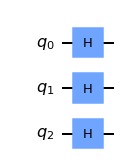

In [13]:
qc_2.draw(output='mpl')

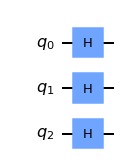

In [14]:
qc_3.draw(output='mpl')

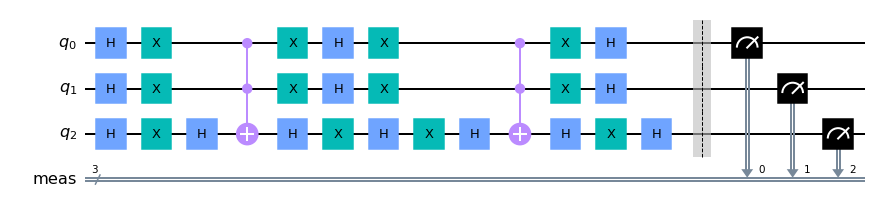

In [15]:
for t in range(1): 
    phase_oracle(qc_1)
    diffuser(qc_1)
    
qc_1.measure_all()

qc_1.draw(output='mpl')

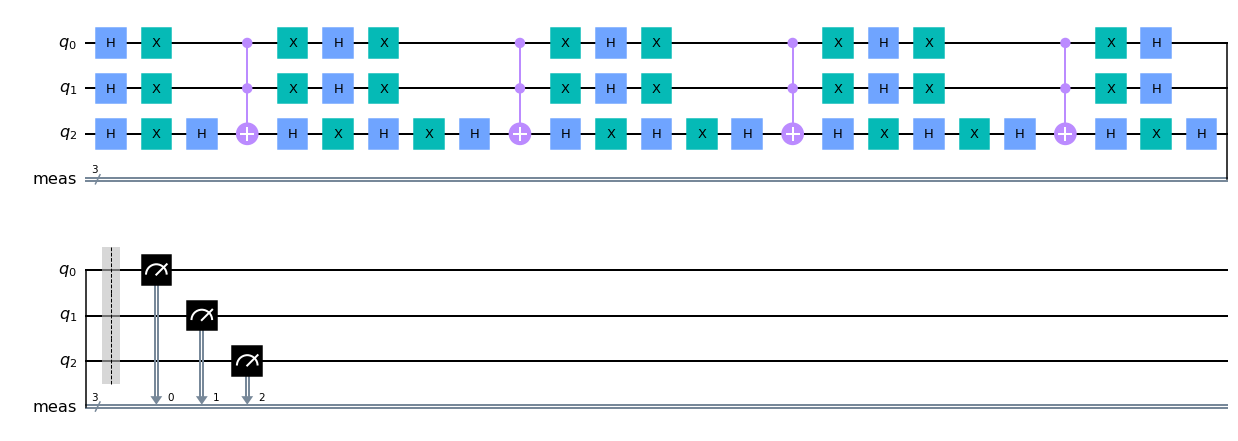

In [16]:
for t in range(2): 
    phase_oracle(qc_2)
    diffuser(qc_2)
    
qc_2.measure_all()

qc_2.draw(output='mpl')

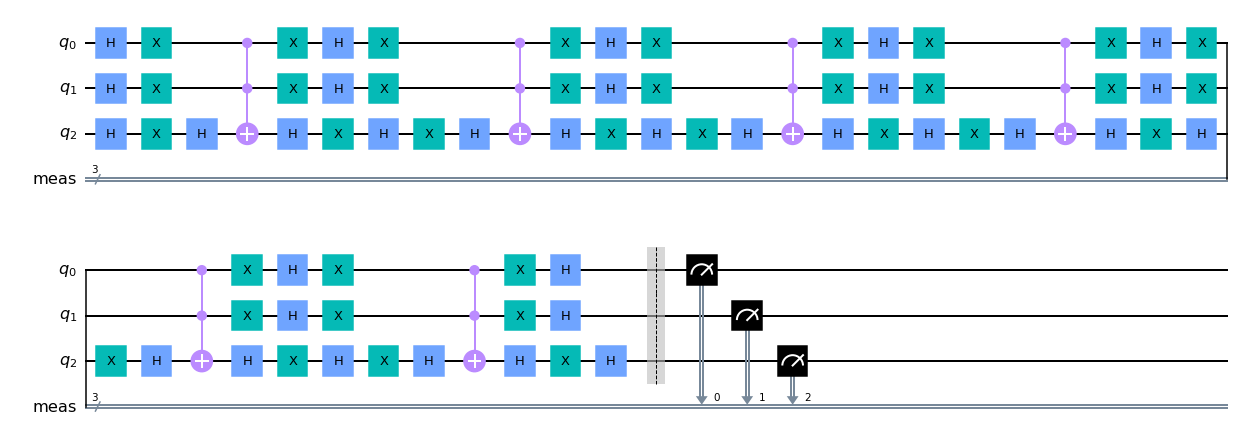

In [17]:
for t in range(3): 
    phase_oracle(qc_3)
    diffuser(qc_3)
    
qc_3.measure_all()

qc_3.draw(output='mpl')

Analisemos agora os resultados de uma simulação para os 3 circuítos.

In [18]:
shots=1024
result1 = execute(qc_1, backend_qasm, shots=shots).result()
counts_sim1 = result1.get_counts(qc_1)

result2 = execute(qc_2, backend_qasm, shots=shots).result()
counts_sim2 = result2.get_counts(qc_2)

result3 = execute(qc_3, backend_qasm, shots=shots).result()
counts_sim3 = result3.get_counts(qc_3)

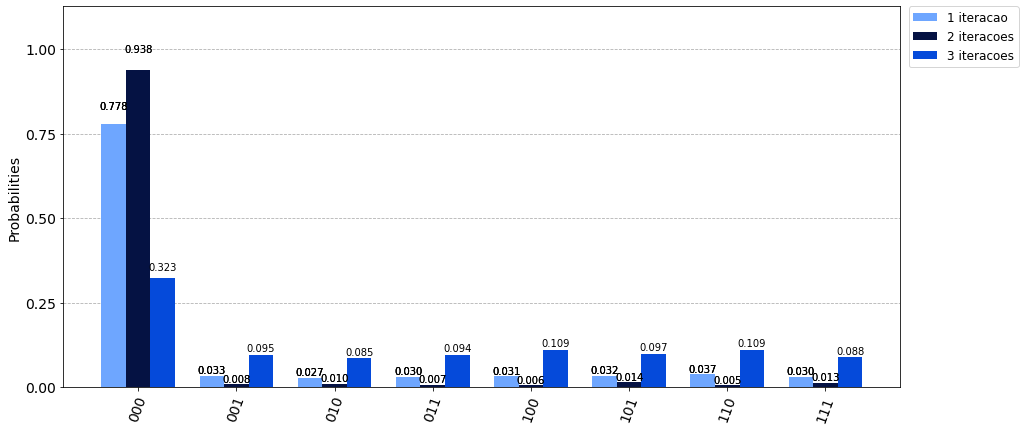

In [19]:
color = ['#6ea6ff','#051243','#054ada']
legend = ["1 iteracao","2 iteracoes","3 iteracoes"]
plot_histogram([counts_sim1, counts_sim2, counts_sim3], legend=legend, color=color,figsize=(15, 7))

Como podemos verificar, é com 2 iterações que se obtém os melhores resultados. Por isso, daqui para a frente iremos utilizar o circuíto com 2 iterações.

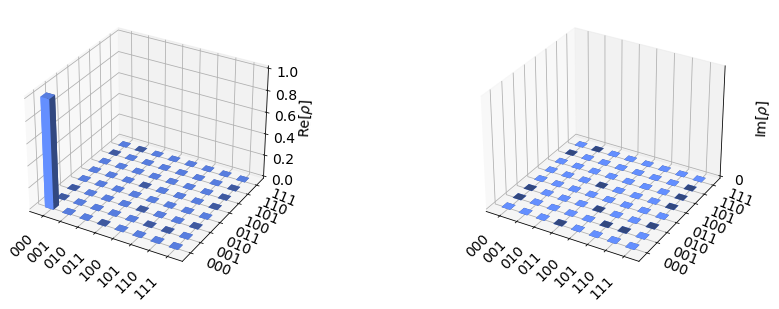

In [20]:
result = execute(qc_2, backend_state).result()
psi1  = result.get_statevector(qc_2)
plot_state_city(psi1)

## Noise simulator para otimização

In [21]:
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise

In [22]:
provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [23]:
# Backend overview
import qiskit.tools.jupyter
%qiskit_backend_overview

In [24]:
my_provider_ibmq = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

backend_device = my_provider_ibmq.get_backend('ibmq_manila')

coupling_map = backend_device.configuration().coupling_map

# Construct the noise model from backend properties
noise_model = NoiseModel.from_backend(backend_device)

basis_gates = noise_model.basis_gates

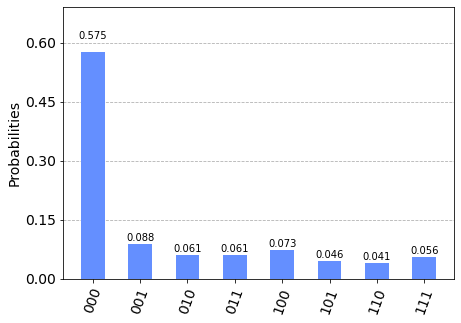

In [25]:
# Execute noisy simulation and get counts
result_noise = execute(qc_2, backend_qasm,
                            noise_model=noise_model,
                            coupling_map=coupling_map,
                            basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(qc_2)
plot_histogram(counts_noise)

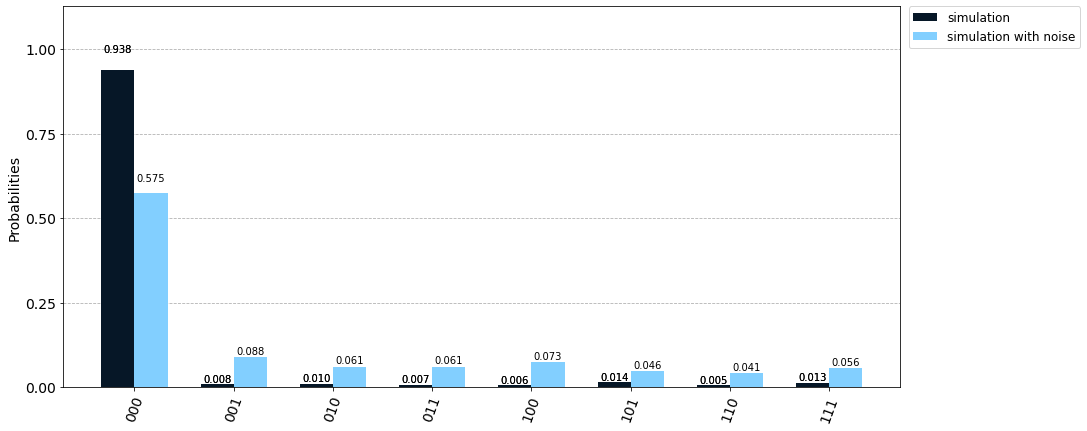

In [26]:
plot_histogram([counts_sim2, counts_noise], legend= ['simulation','simulation with noise'],color=['#061727','#82cfff'],figsize=(15, 7))

## Execução em máquina quântica real

Ao escolhermos a máquina onde vamos correr o programa, a decisão é feita tendo em conta o número de qubits necessários e os qubits que cada máquina tem. Foi usado também como fator de decisão o número de tarefas pendentes de cada máquina para não prolongar demasiado o tempo de espera. Por fim, tivemos ainda em atenção a média de erros de cada máquina e o "tempo de vida" dos qubits.

In [27]:
print("Running on: ", backend_device)

Running on:  ibmq_manila


In [28]:
%qiskit_job_watcher

job_r = execute(qc_2, backend_device, shots=shots)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

JOB ID: 60bb3a5436b2be4a7524f9d2


In [29]:
job_get=backend_device.retrieve_job("60bb3a5436b2be4a7524f9d2")

result_real = job_get.result()
counts_real = result_real.get_counts(qc_2)

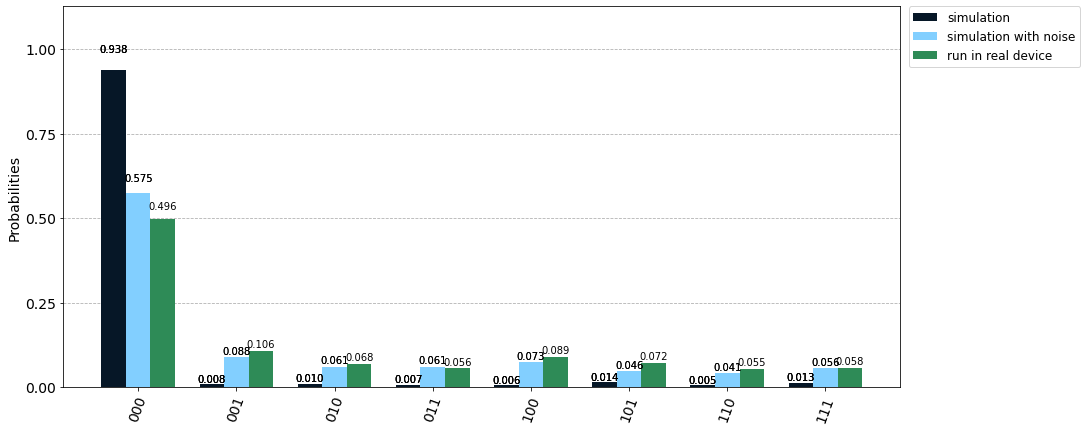

In [30]:
legend = ['simulation','simulation with noise','run in real device']
color =  ['#061727','#82cfff','#2e8b57']

plot_histogram([counts_sim2, counts_noise, counts_real], legend=legend, color=color, figsize=(15, 7))

## Optimização

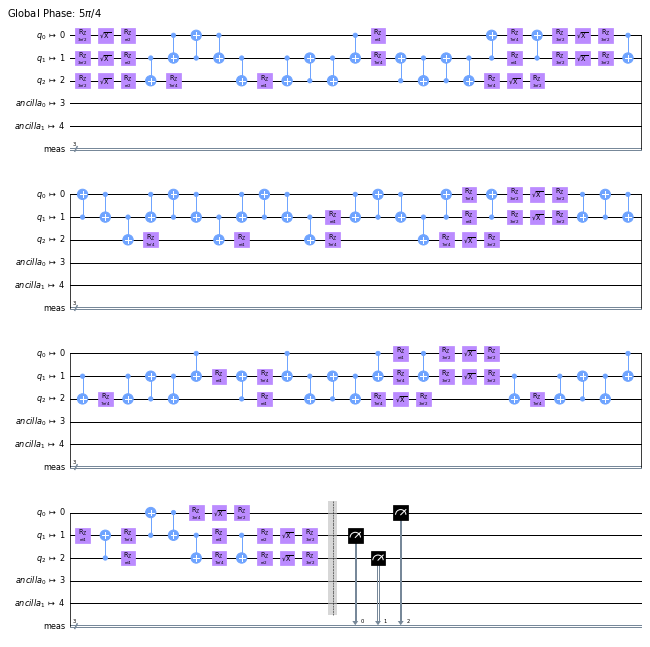

In [31]:
from qiskit.compiler import transpile

qc_t_real = transpile(qc_2, backend=backend_device)

qc_t_real.draw(output='mpl', scale=0.5)

In [32]:
qc_t_real.depth()

87

In [33]:
qc_2.depth()

26

Após alguns testes com vários níveis de otimização, verificamos que os melhores resultados foram obtidos com o nível 2 e como tal, foi esse o número de otimização escolhido.

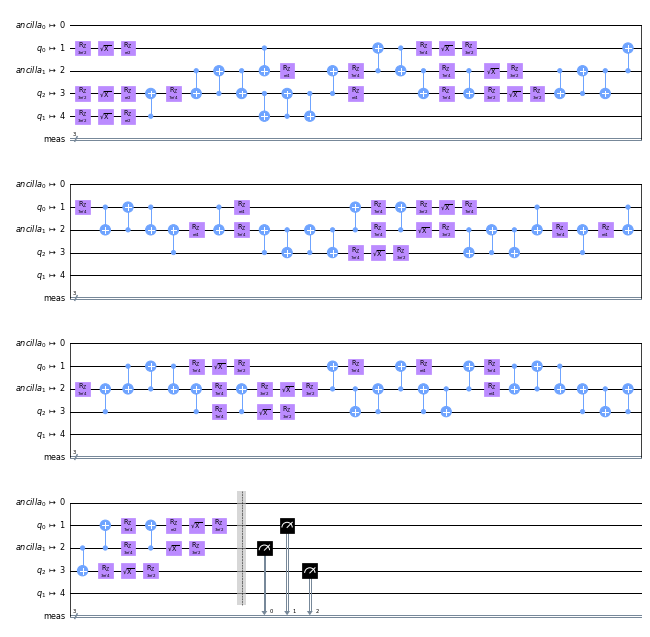

In [34]:
qc_optimized = transpile(qc_2, backend=backend_device, optimization_level=2)
qc_optimized.draw(output='mpl', scale=0.5)

In [35]:
qc_optimized.depth()

83

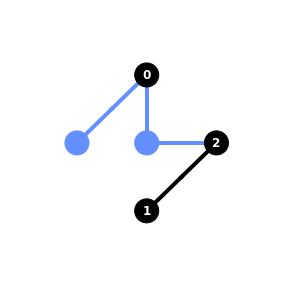

In [36]:
from qiskit.visualization import plot_circuit_layout
plot_circuit_layout(qc_optimized, backend_device)

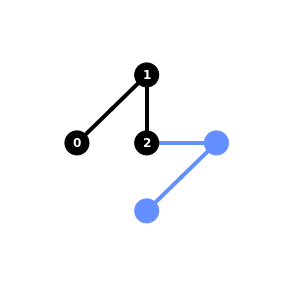

In [37]:
plot_circuit_layout(qc_t_real, backend_device)

In [38]:
job_exp = execute(qc_optimized, backend_device, shots=shots)

# job_id allows you to retrive old jobs
jobID = job_exp.job_id()

print('JOB ID: {}'.format(jobID))

job_exp.result().get_counts(qc_optimized)

JOB ID: 60bb3ab2b454d0bab2aa633d


{'000': 451,
 '001': 90,
 '010': 100,
 '011': 73,
 '100': 60,
 '101': 85,
 '110': 79,
 '111': 86}

In [39]:
job_get_o=backend_device.retrieve_job("60bb3ab2b454d0bab2aa633d")
result_real_o = job_get_o.result(timeout=3600, wait=5)

counts_opt = result_real_o.get_counts(qc_optimized)

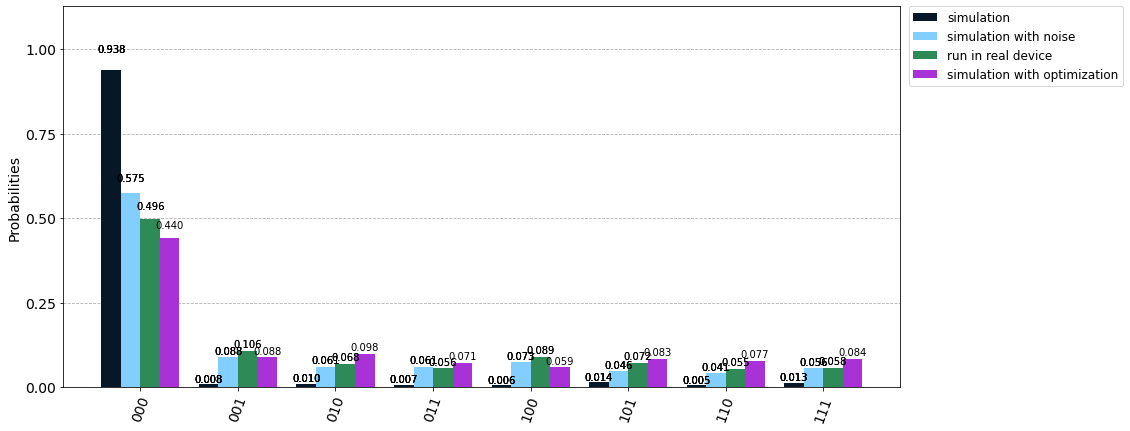

In [40]:
legend = ['simulation','simulation with noise','run in real device','simulation with optimization']
color =  ['#061727','#82cfff','#2e8b57','#a931d8']

plot_histogram([counts_sim2, counts_noise, counts_real, counts_opt], legend=legend, color=color, figsize=(15, 7))

## Mitigação de erros com IGNIS

O objetivo final deste trabalho consiste no tratamento de erros, recorrendo ao módulo Ignis.
Começamos por gerar a lista de circuitos de calibração de medição para todo o
espaço de Hilbert. No nosso caso em concreto, como temos 3 qubits, iremos ter 8 circuitos
de calibração.

In [41]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

In [42]:
# Generate the calibration circuits
qr = QuantumRegister(n_qubits)

# meas_calibs:
# list of quantum circuit objects containing the calibration circuits
# state_labels:
# calibration state labels
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')

In [43]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

O passo seguinte consiste em calcular-se a matriz de calibração uma vez que, caso não exista ruído na
maquina escolhida, a matriz de calibração é a matriz identidade com 8 linhas e 8 colunas.

Poderemos então observar que após a execução dos circuitos de calibração num simulador, a matriz obtida é a matriz identidade logo não tem ruído.

In [44]:
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


Em contrapartida, se usarmos o IBM_Q para executar o circuito de calibração iremos obter uma matriz diferente da matriz identidade. Isto deve-se ao facto de estarmos a utilizar uma máquina real e como tal irá haver ruído.

In [45]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)
jobID_run_ignis = job_ignis.job_id()
print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60bb3ae9b454d0c1dfaa6341


[[0.93554688 0.04882812 0.03515625 0.         0.04589844 0.00195312
  0.00292969 0.        ]
 [0.00878906 0.921875   0.         0.04296875 0.         0.02539062
  0.         0.        ]
 [0.04589844 0.00292969 0.94921875 0.03320312 0.00097656 0.
  0.03515625 0.00390625]
 [0.         0.01757812 0.00878906 0.91308594 0.         0.00292969
  0.         0.03125   ]
 [0.00683594 0.00195312 0.00097656 0.         0.89746094 0.04199219
  0.03222656 0.        ]
 [0.         0.00683594 0.         0.00097656 0.0078125  0.90625
  0.         0.04589844]
 [0.00292969 0.         0.00585938 0.         0.046875   0.00292969
  0.91699219 0.04589844]
 [0.         0.         0.         0.00976562 0.00097656 0.01855469
  0.01269531 0.87304688]]


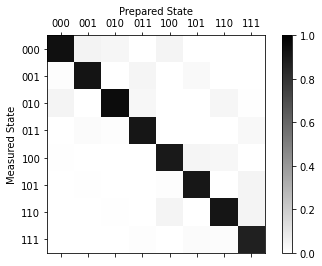

In [46]:
job_get=backend_device.retrieve_job("60bb3ae9b454d0c1dfaa6341")
cal_result = job_get.result()

meas_fitter = CompleteMeasFitter(cal_result, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

meas_fitter.plot_calibration()

In [47]:
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.914185


Por fim, vamos aplicar um filtro com base na matriz de calibração de maneira a filtrarmos os resultados.

In [48]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_real)
mitigated_counts = mitigated_results.get_counts()

Com isto, podemos obter um gráfico onde é possível comparar os valores obtidos na execução na máquina real (antes e depois da mitigação de erros) com os valores que seriam ideais.

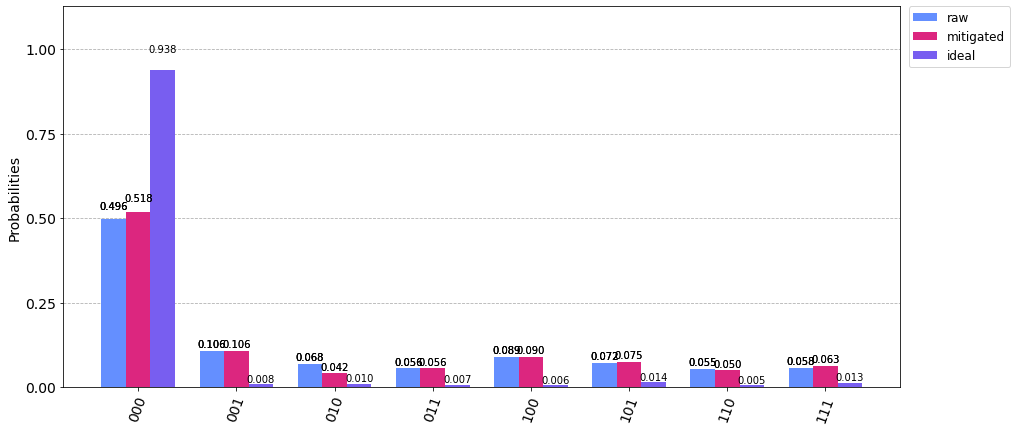

In [49]:
plot_histogram([counts_real, mitigated_counts, counts_sim2], legend=['raw', 'mitigated', 'ideal'],figsize=(15, 7))

In [50]:
%qiskit_disable_job_watcher

### Bibliografia

Complete 3-Qubit Grover Search on a Programmable Quantum Computer - C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath, C. Monroe1

Algoritmo de Grover: https://qiskit.org/textbook/ch-algorithms/grover.html 